In [1]:
import pandas as pd
df = pd.read_csv('New Data.csv') # Dataset is now stored in a Pandas Dataframe

print(df.head())

   Id                                           Judgment  Judgment Status
0   1  appeal judgment decree bombay high court stone...                1
1   2  application article 32 1 constitution enforcem...                2
2   3  appeal judgment high court hyderabad article 3...                0
3   4  appeal article 3744 constitution judgment decr...                0
4   5  petitions art 136 constitution praying special...                3


In [2]:
sentences = df[['Judgment','Judgment Status']]

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(sentences,  test_size=0.25, random_state=42)

In [3]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(df_train['Judgment Status'])
y_test = to_categorical(df_test['Judgment Status'])

In [4]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
LegalBert = TFAutoModelForSequenceClassification.from_pretrained("nlpaueb/legal-bert-base-uncased", num_labels=4)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=df_train.Judgment.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=df_test.Judgment.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [6]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model

In [8]:
max_len = 100

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = LegalBert(input_ids, attention_mask = input_mask)[0]
out = Dense(128, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)

BERT = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
BERT.layers[2].trainable = True

In [9]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy')

# Compile the model
BERT.compile(
    optimizer = optimizer,
    loss=loss, 
    metrics = metric)

In [10]:
gxtrain_history = BERT.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),s
  epochs=10,
    batch_size=64
)

Epoch 1/10


C:\Users\saray\anaconda3\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 96s 22s/step - loss: 1.3682 - balanced_accuracy: 0.3958 - val_loss: 1.3592 - val_balanced_accuracy: 0.3625
Epoch 2/10
4/4 [==============================] - 100s 25s/step - loss: 1.3494 - balanced_accuracy: 0.4083 - val_loss: 1.3535 - val_balanced_accuracy: 0.3625
Epoch 3/10
4/4 [==============================] - 96s 25s/step - loss: 1.3471 - balanced_accuracy: 0.4000 - val_loss: 1.3490 - val_balanced_accuracy: 0.3625
Epoch 4/10
4/4 [==============================] - 98s 25s/step - loss: 1.3349 - balanced_accuracy: 0.4000 - val_loss: 1.3474 - val_balanced_accuracy: 0.3625
Epoch 5/10
4/4 [==============================] - 91s 23s/step - loss: 1.3321 - balanced_accuracy: 0.4000 - val_loss: 1.3413 - val_balanced_accuracy: 0.3625
Epoch 6/10
4/4 [==============================] - 89s 22s/step - loss: 1.3149 - balanced_accuracy: 0.4000 - val_loss: 1.3304 - val_balanced_accuracy: 0.3625
Epoch 7/10
4/4 [==============================] - 84s 21s/step - los

In [11]:
predicted_raw = BERT.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]s

3/3 [==============================] - 11s 3s/step


array([0.36268613, 0.60736305, 0.358513  , 0.30487776], dtype=float32)

In [12]:
import numpy as np

y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = df_test['Judgment Status']

In [13]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_true, y_predicted))

print(accuracy_score(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.38      1.00      0.55        29
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        16

    accuracy                           0.36        80
   macro avg       0.10      0.25      0.14        80
weighted avg       0.14      0.36      0.20        80

0.3625


C:\Users\saray\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saray\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saray\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
x_train ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']}

loss, accuracy = BERT.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.4083


In [15]:
x_test = {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}

loss, accuracy = BERT.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.3625


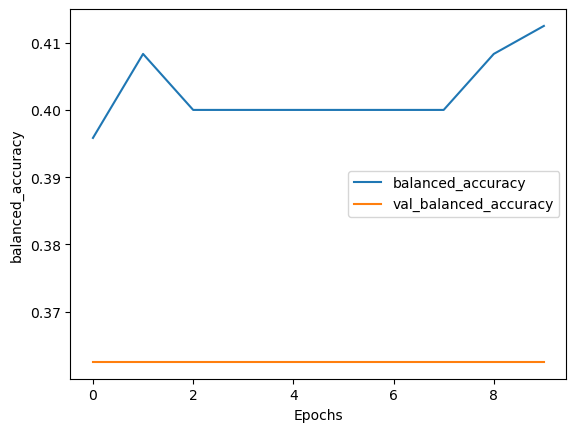

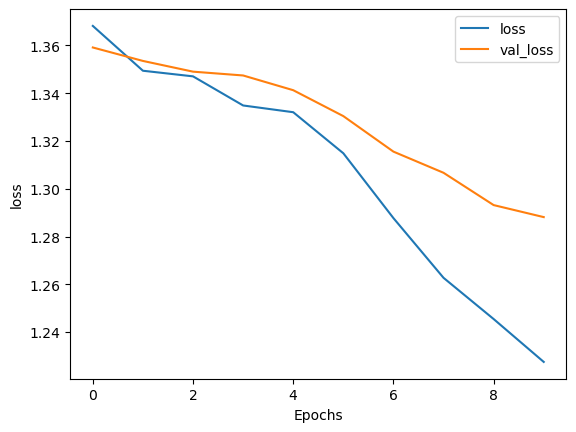

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(gxtrain_history, "balanced_accuracy")
plot_graphs(gxtrain_history, "loss")

In [18]:
sentences = df['Judgment']
y = df['Judgment Status']

from sklearn.model_selection import train_test_split

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=42)

In [19]:
from keras.preprocessing.text import Tokenizer

tokenize = Tokenizer(num_words=10000)
tokenize.fit_on_texts(sentences_train)

train_X = tokenize.texts_to_sequences(sentences_train)
test_X = tokenize.texts_to_sequences(sentences_test)

vocab_size = len(tokenize.word_index) + 1  

In [20]:
from keras_preprocessing.sequence import pad_sequences

x_train = pad_sequences(train_X, padding='post', maxlen=1000)  
x_test = pad_sequences(test_X, padding='post', maxlen=1000)

In [21]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [22]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [23]:
embed_dim = 32  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 1000

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(4, activation="softmax")(x)

transformer = Model(inputs=inputs, outputs=outputs)

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

transformer.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(x_train, y_train, 
                    batch_size=64, epochs=50, 
                    validation_data=(x_test, y_test),
                    callbacks = [callback]
                   )

Epoch 1/50
4/4 [==============================] - 10s 2s/step - loss: 1.3522 - accuracy: 0.3958 - val_loss: 1.3454 - val_accuracy: 0.3875
Epoch 2/50
4/4 [==============================] - 10s 3s/step - loss: 1.2726 - accuracy: 0.4250 - val_loss: 1.3045 - val_accuracy: 0.3875
Epoch 3/50
4/4 [==============================] - 14s 3s/step - loss: 1.2172 - accuracy: 0.4667 - val_loss: 1.3005 - val_accuracy: 0.3500
Epoch 4/50
4/4 [==============================] - 13s 3s/step - loss: 1.1821 - accuracy: 0.4542 - val_loss: 1.3014 - val_accuracy: 0.3500
Epoch 5/50
4/4 [==============================] - 13s 3s/step - loss: 1.1142 - accuracy: 0.4750 - val_loss: 1.3120 - val_accuracy: 0.3625
Epoch 6/50
4/4 [==============================] - 13s 3s/step - loss: 1.0306 - accuracy: 0.5167 - val_loss: 1.3112 - val_accuracy: 0.3500


In [26]:
loss, accuracy = transformer.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = transformer.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6000
Testing Accuracy:  0.3500


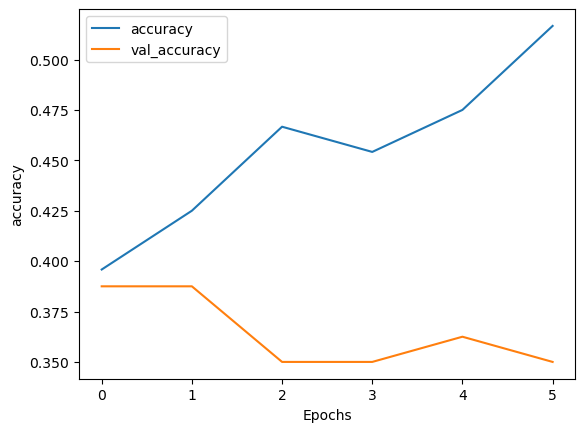

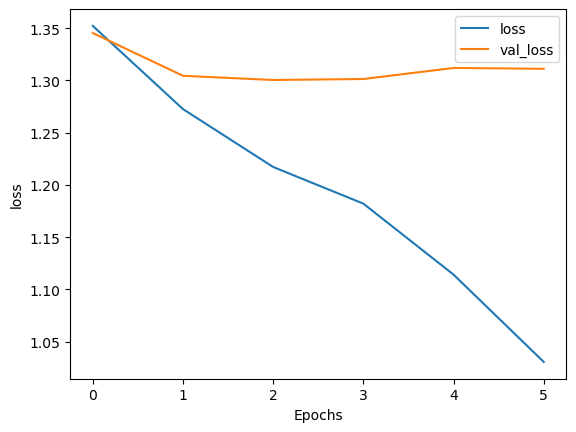

In [27]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")